Let's first install some tools.

In [ ]:
# pip install scikit-learn scikit-lego

## Voting Classifier

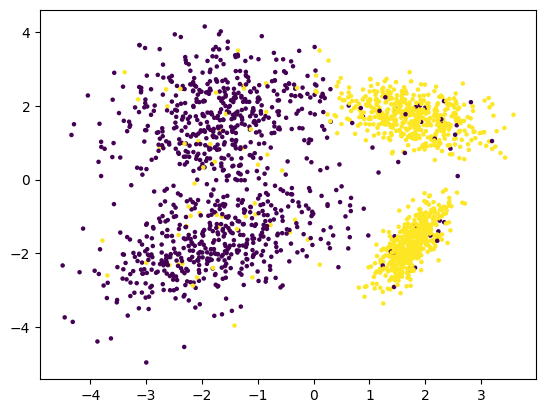

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # creates 1 separating line
from sklearn.neighbors import KNeighborsClassifier # points that are closest
from sklearn.ensemble import VotingClassifier # input list of estimators with weights, can use weights in grid search
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=2000, n_features=2,
                           n_redundant=0, random_state=21,
                           class_sep=1.75, flip_y=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

In [2]:
def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens3");

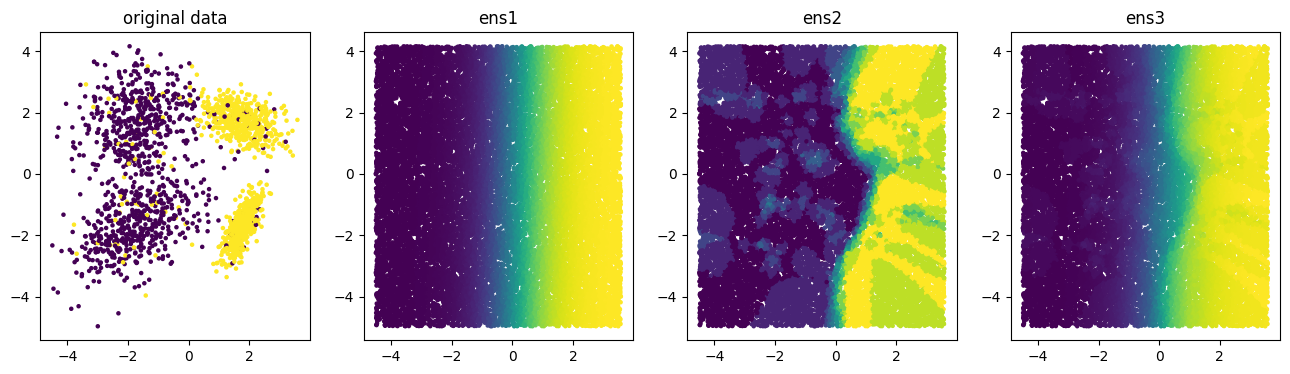

In [3]:
clf1 = LogisticRegression().fit(X, y)
clf2 = KNeighborsClassifier(n_neighbors=10).fit(X, y)
clf3 = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2)],
                        voting='soft', # averaging proba values
                        weights=[10.5, 2.5]) # these are the weights I would like to associate with both models
clf3.fit(X, y)

make_plots()

# allows for a lot of flexibility and effectiveness

## Threshold

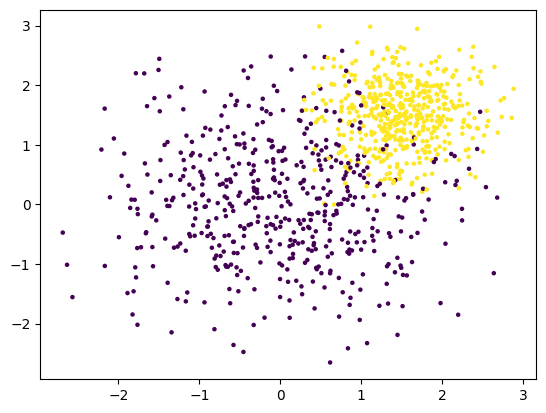

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from sklego.meta import Thresholder

X, y = make_blobs(1000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

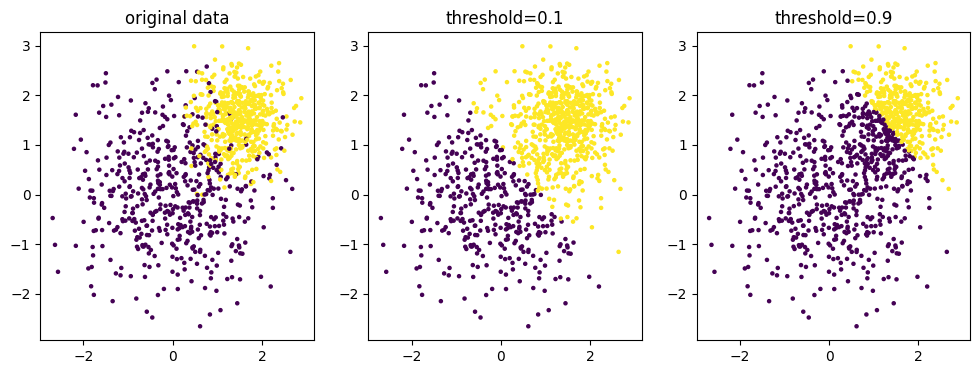

In [5]:
m1 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1).fit(X, y)
m2 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.9).fit(X, y)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
plt.title("original data")
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=m1.predict(X), s=5)
plt.title("threshold=0.1")
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=m2.predict(X), s=5)
plt.title("threshold=0.9");

In [6]:
pipe = Pipeline([
    ("model", Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])

mod = GridSearchCV(estimator=pipe,
                  param_grid = {"model__threshold": np.linspace(0.1, 0.9, 50)},
                  scoring={"precision": make_scorer(precision_score),
                            "recall": make_scorer(recall_score),
                            "accuracy": make_scorer(accuracy_score)},
                  refit="precision",
                  cv=5)

mod.fit(X, y);

## Grouped Models

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklego.datasets import load_chicken
from sklego.preprocessing import ColumnSelector

df = load_chicken(as_frame=True)

def plot_model(model):
    df = load_chicken(as_frame=True)
    model.fit(df[['diet', 'time']], df['weight'])
    metric_df = df[['diet', 'time', 'weight']].assign(pred=lambda d: model.predict(d[['diet', 'time']]))
    metric = mean_absolute_error(metric_df['weight'], metric_df['pred'])
    plt.figure(figsize=(12, 4))
    # plt.scatter(df['time'], df['weight'])
    for i in [1, 2, 3, 4]:
        pltr = metric_df[['time', 'diet', 'pred']].drop_duplicates().loc[lambda d: d['diet'] == i]
        plt.plot(pltr['time'], pltr['pred'], color='.rbgy'[i])
    plt.title(f"linear model per group, MAE: {np.round(metric, 2)}");

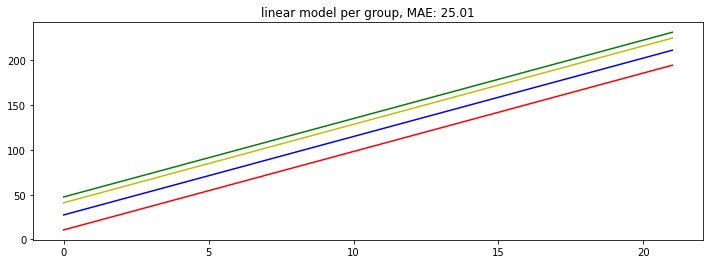

In [ ]:
feature_pipeline = Pipeline([
    ("datagrab", FeatureUnion([ # splits features into 2 buckets: time and diet
        ("discrete", Pipeline([
            ("grab", ColumnSelector("diet")),
            ("encode", OneHotEncoder(categories="auto", sparse=False)) # diet is encoded
        ])),
        ("continuous", Pipeline([
            ("grab", ColumnSelector("time")),
            ("standardize", StandardScaler()) # time is scaled
        ]))
    ]))
])

pipe = Pipeline([
    ("transform", feature_pipeline),
    ("model", LinearRegression())
])

plot_model(pipe)

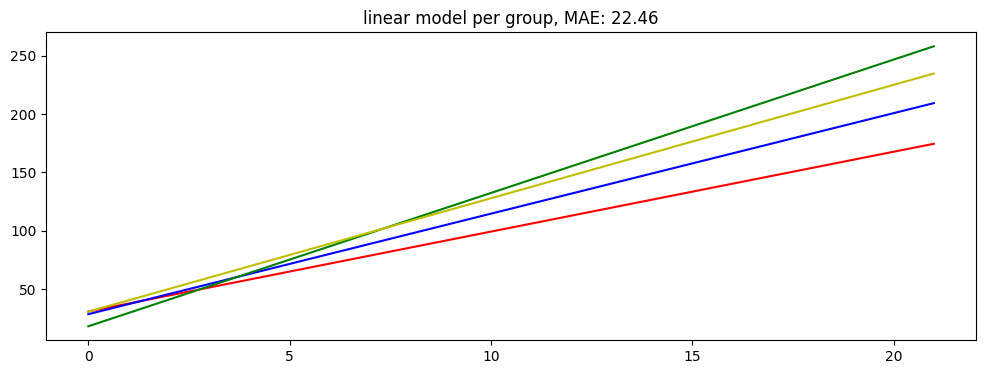

In [8]:
from sklego.meta import GroupedPredictor
mod = GroupedPredictor(LinearRegression(), groups=["diet"]) # training a model for each diet
plot_model(mod)

### Zero Inflated Regression

In [9]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklego.meta import ZeroInflatedRegressor

# Note the final line of code in this block. We're setting y=0 for all weekend dates
# while we simulate standard regression data for all the other dates.
df = (pd.DataFrame({'dt': pd.date_range("2018-01-01", "2021-01-01")})
      .assign(x=lambda d: np.random.normal(0, 1, d.shape[0]))
      .assign(weekend = lambda d: (d['dt'].dt.weekday >= 5).astype(np.int16))
      .assign(y=lambda d: np.where(d['weekend'], 0, 1.5 + 0.87 * d['x'] + np.random.normal(0, 0.2, d.shape[0]))))

In [ ]:
X, y = df[['x', 'weekend']].values, df['y'].values

In [3]:
zir = ZeroInflatedRegressor(
    classifier=LogisticRegression(),
    regressor=Ridge()
)

lr = Ridge(random_state=0)

print('ZIR r²:', cross_val_score(zir, X, y).mean())
print(' LR r²:', cross_val_score(lr, X, y).mean())

ZIR r²: 0.9700375284030283
 LR r²: 0.8112455951044073


### Decay

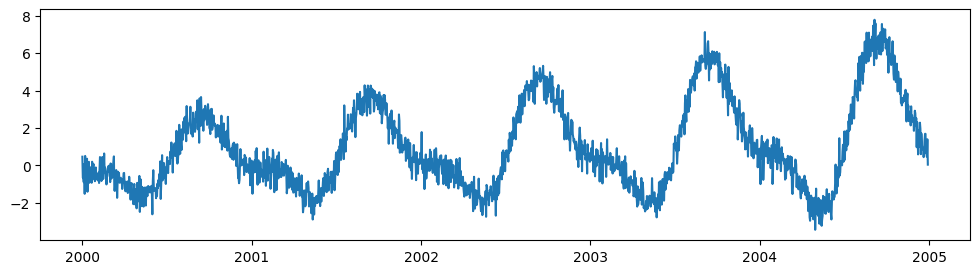

In [16]:
from sklearn.dummy import DummyRegressor
from sklego.meta import GroupedPredictor, DecayEstimator
from sklego.meta._decay_utils import exponential_decay
from sklego.datasets import make_simpleseries
import matplotlib.pylab as plt 

yt = make_simpleseries(seed=1)
dates = pd.date_range("2000-01-01", periods=len(yt))
df = (pd.DataFrame({"yt": yt,
                  "date": dates})
      .assign(m=lambda d: d.date.dt.month)
      .reset_index())

plt.figure(figsize=(12, 3))
plt.plot(dates, make_simpleseries(seed=1)); # shape amplified as time goes on

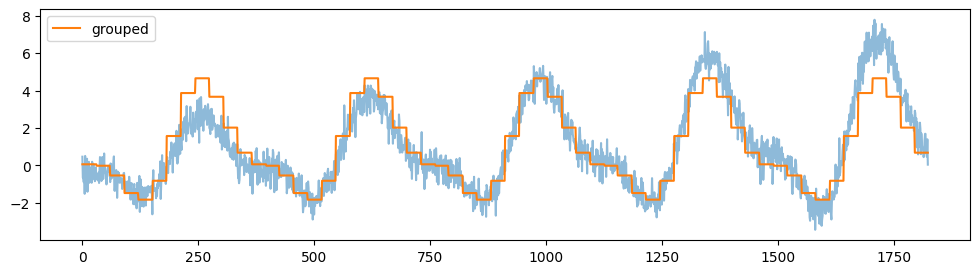

In [ ]:
mod1 = (GroupedPredictor(DummyRegressor(), groups=["m"]) # calculate mean for every month
  .fit(df[['m']], df['yt']))

plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.legend(); # undershooting in recent years, overshooting in past

In [12]:
_ = DummyRegressor().fit
?_

Signature: _(X, y, sample_weight=None)
Docstring:
Fit the baseline regressor.

Parameters
----------
X : array-like of shape (n_samples, n_features)
    Training data.

y : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Target values.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

Returns
-------
self : object
    Fitted estimator.
File:      /Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/dummy.py
Type:      method

In [14]:
help(DecayEstimator)

Help on class DecayEstimator in module sklego.meta.decay_estimator:

class DecayEstimator(sklearn.base.MetaEstimatorMixin, sklearn.base.BaseEstimator)
 |  DecayEstimator(
 |      model,
 |      decay_func='exponential',
 |      check_input=False,
 |      decay_kwargs=None
 |  )
 |
 |  Morphs an estimator such that the training weights can be adapted to ensure that points that are far away have
 |  less weight.
 |
 |  This meta estimator will only work for estimators that allow a `sample_weights` argument in their `.fit()` method.
 |  The meta estimator `.fit()` method computes the weights to pass to the estimator's `.fit()` method.
 |
 |  !!! warning
 |      It is up to the user to sort the dataset appropriately.
 |
 |  !!! warning
 |      By default all the checks on the inputs `X` and `y` are delegated to the wrapped estimator.
 |      To change such behaviour, set `check_input` to `True`.
 |      Remark that if the check is skipped, then `y` should have a `shape` attribute, which is

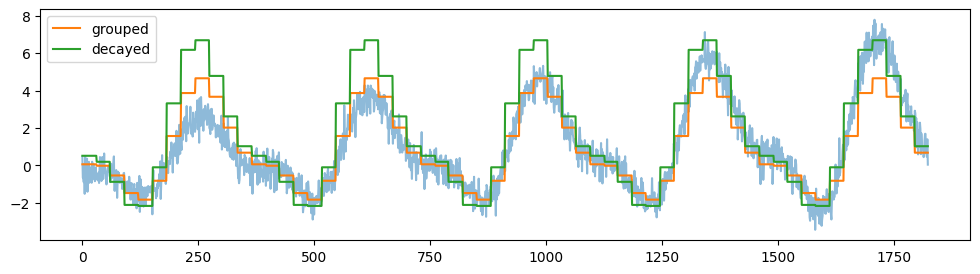

In [29]:
mod1 = (GroupedPredictor(DummyRegressor(), groups=["m"]) # DummyRegressor = meta model
  .fit(df[['m']], df['yt']))

mod2 = GroupedPredictor(
    DecayEstimator(
        model=DummyRegressor(),                    # name of the time column in X
        decay_func="exponential",
        decay_kwargs={"decay_rate":0.9}            # MUST be a dict
    ),
    groups=["m"]
).fit(df[['index', 'm']], df['yt'])

plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.plot(mod2.predict(df[['index', 'm']]), label="decayed")
plt.legend();